In [9]:
from scipy.linalg import expm, sinm, cosm
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
class KalmanFilter(object):
    
    def __init__(self, R, DT, SIGMA_POS_M, SIGMA_VEL_M, SIGMA_W_BIB_M, SIGMA_SD_POS, SIGMA_SD_VEL, m_A, m_B, v_U, v_X_0):
        self.R = R
        self.DT = DT
        
        self.m_A = m_A
        self.m_B = m_B
        self.v_U = v_U
        self.m_Q = np.matrix([[SIGMA_SD_POS**2, 0],
                              [0, SIGMA_SD_VEL**2]])

        self.m_C = np.matrix([[1, 0],
                              [0, 1],
                              [0, 1/R]])
        self.m_R = np.matrix([[SIGMA_POS_M**2, 0, 0],
                              [0, SIGMA_VEL_M**2, 0],
                              [0, 0, SIGMA_W_BIB_M**2]])
        
        self.I = np.matrix([[1, 0],            
                            [0, 1]])

        
        #discretizing continuous time system to X(n+1) = phi*X(n) + tau*U(n)
        
        #phi = e^(A*dt)
        self.m_phi = expm(DT*self.m_A)
        #tau = (phi - I)(A^-1)B
        self.m_tau = (self.m_phi - self.I)*(np.linalg.inv(self.m_A))*self.m_B
          
        
        #initial state and error
        self.v_X = v_X_0
        self.m_P = np.matrix([[1, 0],
                              [0, 1]])

    def kf_predict(self):
    
        #prediciting state and covariance of error in state from model parameters
        self.v_X = np.dot(self.m_phi, self.v_X) + np.dot(self.m_tau, self.v_U)
        self.m_P = np.dot(np.dot(self.m_phi, self.m_P), self.m_phi.T) + self.m_Q
        
        return self.v_X
    
    def kf_update(self, v_y_m):
        
        #S = CPC^T + R
        m_S = np.dot(self.m_C, np.dot(self.m_P, self.m_C.T)) + self.m_R
        
        #updating Kalman Gain
        m_K = np.dot(np.dot(self.m_P, self.m_C.T), np.linalg.inv(m_S))
        
        #updating state
        self.v_X = self.v_X + np.dot(m_K, (v_y_m - np.dot(self.m_C, self.v_X)))
        
        #updating error
        I = np.eye(self.m_C.shape[1])
        self.m_P = (I - (m_K * self.m_C)) * self.m_P
        
    def real_ode(self, v_X, r_t):

        m_X_st = self.m_A*np.matrix(v_X).T + self.m_B*self.v_U
        v_dpdt_st = m_X_st[0, 0]
        v_dvdt_st = m_X_st[1, 0]
        
        return [v_dpdt_st, v_dvdt_st]

        

In [15]:
def main():
       
    '''
    Here, we define the model parameters of continuous time state space equations, i.e., 
    dX/dt = AX + BU + w
    Y = CX + v
    where X is the state, Y is the measurement, U is the control input vector.
    w is state disturbances with covariance matrix Q, v is measurement noice vector with covariance matrix R.
    
    I have considered the system to be a robot moving in one direction and having state variables position and velocity. 
    Position, velocity and angular velocity of the wheels of the robot are measured, fixing matrix C. Although, matrices 
    A, B and U (trajectories and control inputs) can be varied.
    
    The size of the matrices are fixed as X - 2x1, A - 2x2, B - 2x2, U - 2x1, Y - 3x1, C - 3x2.
    '''
    
    #simulation parameters
    T = 3
    DT = 0.03
    r_t = np.arange(0, T, DT)
     
    #inputs
    #radius of the wheel
    R = 0.05
    
    #standard deviation in measurement errors of position, velocity and angular velocity
    SIGMA_POS_M = 0.02
    SIGMA_VEL_M = 1
    SIGMA_W_BIB_M = 5
    
    #standard deviation of state disturbances of position and velocity
    SIGMA_SD_POS = 0.0
    SIGMA_SD_VEL = 0.05
    
    #dX/dt = AX + BU + Q
    m_A = np.matrix([[0, 2],
                     [-100, -2]])
    m_B = np.matrix([[1, 0],
                     [0, 1]])
    v_U = np.matrix([[0],
                     [1]])
    
    #initial state
    v_X_0 = np.matrix([[0], [25]])
    
    #creating Kalman Filter object
    kf = KalmanFilter(R, DT, SIGMA_POS_M, SIGMA_VEL_M, SIGMA_W_BIB_M, SIGMA_SD_POS, SIGMA_SD_VEL, m_A, m_B, v_U, v_X_0)
    m_predictions_st = []
    m_measurements_m = [[0],[0],[0]]

    
    #solving DE to get model track
    m_real_track_st = np.matrix(odeint(kf.real_ode, np.squeeze(np.array(v_X_0)).tolist(), r_t))
    

    for state in m_real_track_st:
        
        #Generating mesurement
        state = state.T
        v_y_m = np.dot(kf.m_C, state) + np.matrix([[np.random.normal(0, SIGMA_POS_M)],
                                  [np.random.normal(0, SIGMA_VEL_M)],
                                  [np.random.normal(0, SIGMA_W_BIB_M)]])
        m_measurements_m = np.append(m_measurements_m, v_y_m, axis = 1)
        
        #Kalman Filter application
        kf.kf_predict()       
        m_predictions_st.append(kf.v_X)
        kf.kf_update(v_y_m)
    
    
    m_measurements_m = np.delete(m_measurements_m, 0, 1)
    v_positions_m = np.array(m_measurements_m)[0]
    v_velocities_m = np.array(m_measurements_m)[1]
    v_positions_kalman_st = np.array(m_predictions_st).T[0][0]
    v_velocities_kalman_st = np.array(m_predictions_st).T[0][1]  
     
    #plotting results
    fig1 = plt.figure()
    fig1.suptitle('Example of Kalman filter for tracking a moving object', fontsize=20)
    plt.plot(r_t, v_positions_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,0], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_positions_kalman_st, label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Position (m)', fontsize=10)
    plt.legend()
    
    fig2 = plt.figure()
    fig2.suptitle('Example of Kalman filter for tracking a moving object', fontsize=20)
    plt.plot(r_t, v_velocities_m, label='Measurements', color='b',linewidth=1)
    plt.plot(r_t, np.array(m_real_track_st)[:,1], label='Real Track', color='y', linewidth=1.5)
    plt.plot(r_t, v_velocities_kalman_st, label='Kalman Filter Prediction', color='r', linewidth=1)
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Velocity (m/s)', fontsize=10)
    plt.legend()
    plt.show()

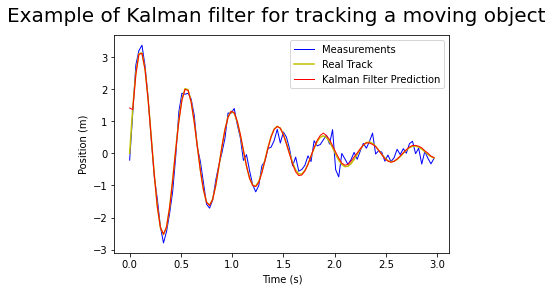

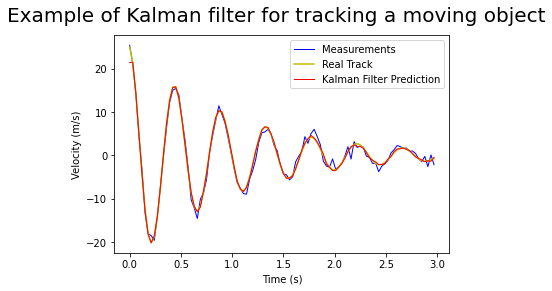

In [16]:
if __name__ == '__main__':
    main()